In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data and NumPy model

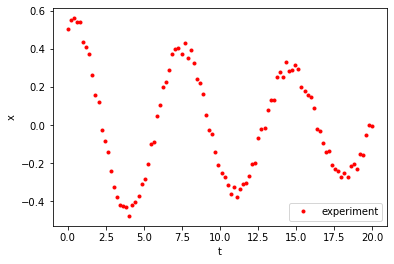

In [2]:
#data
d_out = np.genfromtxt("./data/hooks_law.txt")
t_range=d_out[:,0]
x_range=d_out[:,1]
plt.plot(d_out[:,0],d_out[:,1],"r.",label="experiment")
plt.xlabel("t")
plt.ylabel("x")
#plt.plot(t_range,[true_motion(t,x_0,v_0,k,b,m) for t in t_range],label = "theory curve")
plt.legend(loc=4)

In [3]:
#equation of motion (numpy)
def true_motion(t,x_0,v_0,k,b,m):
    w0 = sqrt(k/m)
    b0 = b/m
    
    if b0**2.-4.*w0**2.>0:
        raise NameError("Not underdamped system! "+ str(b0**2.-4.*w0**2.) )
        
    gamma = 1/2. *sqrt(4*w0**2. - b0**2.)
    print("gamma",4*w0**2. - b0**2.)
    A = x_0
    B = v_0 + 1/2.*gamma*x_0
    print("w0", w0, "b0",b0)
    return (A*cos(t*gamma)+B*sin(t*gamma))*exp(-b0*t/m)

In [4]:
#not really relevant here (isn't called)

def chi_squared(data,parameter_guess):
    x_0,v_0,k,b,m = parameter_guess
    t_array = data[:,0]
    x_experiment = data[:,1]
    x_guess = np.array([true_motion(t,x_0,v_0,k,b,m) for t in t_array])
    
    chi_squared = np.power((x_guess - x_experiment),2)/0.05
    
    return np.sum(chi_squared)
    

In [5]:
#true values
k = 8.25 #spring constant
sigma_x = 0.04 #uncertainty in the x measurement
x_0 = 0.5 #starting position
v_0 = 0.0 #starting velocity
b = 4. #damping
m = 10. #mass

gamma 3.1399999999999997
w0 0.9082951062292475 b0 0.4


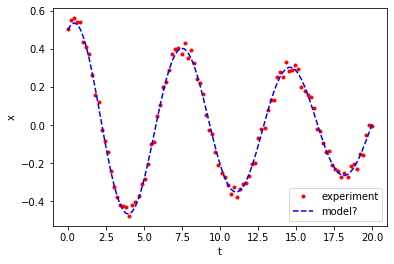

In [6]:
#plotting data and true model

d_out = np.genfromtxt("./data/hooks_law.txt")
t_range=d_out[:,0]
x_range=d_out[:,1]
plt.plot(d_out[:,0],d_out[:,1],"r.",label="experiment")
plt.plot(d_out[:,0],true_motion(d_out[:,0],x_0,v_0,k,b,m),"b--",label="model?")

plt.xlabel("t")
plt.ylabel("x")
#plt.plot(t_range,[true_motion(t,x_0,v_0,k,b,m) for t in t_range],label = "theory curve")
plt.legend(loc=4)

# TensorFlow model and optimization

In [7]:
#defining variables for tensorflow model AND INITIALIZING VARIABLES!

import tensorflow as tf
import numpy as np
rng = np.random

# disable eager execution
tf.compat.v1.disable_eager_execution()

X = tf.Variable([0.50,9.25,2.0], name="variables") # x_0, k, and b, respectively

T = tf.compat.v1.placeholder("float")
Y = tf.compat.v1.placeholder("float")

n_samples = len(d_out[:,0])

In [8]:
#defining EoM in tensorflow

w0 = tf.sqrt(tf.divide(X[1],m))
b0 = tf.divide(X[2],m)


w02 = tf.multiply(4.0,tf.pow(w0,2))
b02 =tf.pow(b0,2)

inner = tf.subtract(w02,b02)
inner1 = tf.pow(inner,1.0/2.0)
gamma = tf.multiply(1/2.,inner1)
    
A = X[0]
B = tf.add(v_0,tf.multiply(1/2.,tf.multiply(gamma,X[0])))
inter1 = tf.multiply(A,tf.cos(tf.multiply(T,gamma)))
inter2 = tf.multiply(B,tf.sin(tf.multiply(T,gamma)))
pred = tf.multiply(tf.add(inter1,inter2),tf.exp(tf.multiply(tf.multiply(-1.0,b0),tf.divide(T,m))))

cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)

In [9]:
#tensorflow optmization./display parameters
lr = 10.0
training_epochs = 1000
display_step = 50

#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-08,)
gradients, variables = zip(*optimizer.compute_gradients(cost))
gradients, _ = tf.clip_by_global_norm(gradients, 0.000000000001)
opt = optimizer.apply_gradients(zip(gradients, variables))

In [10]:
#running just one value through to debug (not needed to run before optimization)

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    print(inner1.eval(feed_dict={T: d_out[:,0], Y:d_out[:,1]}))
    

1.9131126


In [ ]:
#optimization scheme

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(d_out[:,0], d_out[:,1]):
            sess.run(opt, feed_dict={T: x, Y: y})

        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={T: d_out[:,0], Y:d_out[:,1]})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "X=", sess.run(X))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={T: d_out[:,0], Y:d_out[:,1]})
    print("Training cost=", training_cost, "X=", sess.run(X), '\n')


Epoch: 0050 cost= 0.000901511 X= [0.42127  8.123178 2.160953]
Epoch: 0100 cost= 0.000777309 X= [0.41540015 8.027837   2.234439  ]
Epoch: 0150 cost= 0.000716765 X= [0.42134023 8.030303   2.2995229 ]
Epoch: 0200 cost= 0.000690092 X= [0.42337167 8.034188   2.3652172 ]
Epoch: 0250 cost= 0.000645092 X= [0.42827776 8.040814   2.4285982 ]
Epoch: 0300 cost= 0.000629906 X= [0.4291619 8.0483265 2.489309 ]
Epoch: 0350 cost= 0.000601661 X= [0.43202755 8.052196   2.5478344 ]
Epoch: 0400 cost= 0.000566089 X= [0.43641382 8.057364   2.6031888 ]
Epoch: 0450 cost= 0.000537449 X= [0.44007435 8.062374   2.6573231 ]
Epoch: 0500 cost= 0.000510564 X= [0.44390678 8.066561   2.7082238 ]
Epoch: 0550 cost= 0.000495148 X= [0.44554642 8.072329   2.7569044 ]
Epoch: 0600 cost= 0.000483339 X= [0.44653907 8.07833    2.8051994 ]
Epoch: 0650 cost= 0.000465644 X= [0.44902202 8.084103   2.8517392 ]
Epoch: 0700 cost= 0.000450495 X= [0.4510959 8.087908  2.8982246]
Epoch: 0750 cost= 0.000440427 X= [0.4523836 8.0851345 2.9449

In [ ]:
np.random.randn(3,3)

In [ ]:
X = tf.Variable([0.50,9.25,2.0], name="variables")
T = tf.compat.v1.placeholder("float")

f = T**2
r_g = tf.gradients(f,T)

In [ ]:
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    print(sess.run(r_g, feed_dict={T: 3}))
